## TASK 4: PREPARE THE PROPOSALS FOR TRAINING

Summary of procedure:

- Iterate through all images and their annotations.

- Calculate the IoU for each proposal and assign the corresponding label.

- Store the information about proposals and labels in a format useful for training.

- Save the prepared data for use in the object detection model.

In [1]:

import os
import cv2
import selectivesearch
import sys

sys.path.append("..")  # Go up one level, adjust as necessary

from module.utils import  parse_xml, prepare_proposals,get_proposals, calculate_iou, load_image, get_id,calc_recall, calc_abo
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
#import torch 
from torch.utils.data import Dataset
# Moving active directory to root folder to get module to work

In [2]:
img_path = "../Potholes/annotated-images/"
anno_path = "../Potholes/annotated-images/"
# This does not scale. We should save annotation proposals in a file. 

image_count = 10

We use the above function in a class for generating the Pothole images.

In [ ]:


proposal_data, labels = prepare_proposals(img_path, anno_path, 500, 0.5, image_count)



c:\Python312\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [3]:
def visualize_image(image, boxes, proposals=None, scale_x=1.0, scale_y=1.0):
    # Adjust ground truth boxes according to the scale
    adjusted_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in boxes]
    
    # Convert color for display
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw ground truth boxes in blue
    for (xmin, ymin, xmax, ymax) in adjusted_boxes:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Draw Selective Search proposals in green if provided
    if proposals is not None:
        for (x, y, w, h) in proposals:
            x, y, w, h = int(x), int(y), int(w), int(h)

            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
            # cv2.putText(image, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
files = os.listdir(img_path)


image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))


boxes = [parse_xml(anno_path + label_path) for label_path in label_paths[:image_count]]
images = [load_image(img_path + img) for img in image_paths[:image_count]]


# visualize_image(image, boxes=boxes, proposals=proposal_data[0])

In [ ]:
TARGET_WIDTH, TARGET_HEIGHT = 400, 400

# Loop through images, resize if needed, and apply Selective Search
image_counter = 0

for image, boxs, proposals in zip(images, boxes, proposal_data):
    
    
        
    # Calculate scaling factors
    orig_height, orig_width = image.shape[:2]
    scale_x = orig_width
    scale_y = orig_height

    # Resize the image to improve Selective Search efficiency

    # # Run Selective Search on resized image

    # Convert to integer type before passing the image
    # or simply
    # resized_image_int = resized_image.astype(np.uint8)  # if resized_image is in a valid range of 0-255 but in float

    # Use this converted version in operations

    visualize_image(image, boxs, proposals)  # To Display uncomment

    # Break to only visualize a few images
    image_counter += 1
    if image_counter >= 10:
        break

In [ ]:
# To change the number of proposals we will vary the scale on the selectivesearch function 
# (this is done to not truncate and have a better distribution of the proposals)
# scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]
scales = [1, 5, 10, 20, 40, 60, 80, 100, 200, 300]
sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# MAX_IMAGES = 20 # Number of image we will take into account to do the recall

# Keep the recalls in a diccionary
results = {scale: {'num_proposals': 0, 'recall': []} for scale in scales}


# Loop through images to evaluate proposals
image_count = 0
MAX_IMAGES = 20

TARGET_WIDTH = 400
TARGET_HEIGHT = 400
image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))

image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

for img_name, label_name in zip(image_paths, label_paths):
    # Stop processing after reaching the limit of images
    if image_count >= MAX_IMAGES:
        break

    image_path = os.path.join(img_path, img_name)
    xml_path = os.path.join(anno_path, label_name)
        
    # Load image and ground truth
    image = cv2.imread(image_path)
    if os.path.exists(xml_path):
        ground_truth_boxes = parse_xml(xml_path)
            
        # Dimensions for resizing image 
        orig_height, orig_width = image.shape[:2]
        scale_x = orig_width
        scale_y = orig_height
            
        # Resize ground truth boxes
        # resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
        # Resize image and generate proposals
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            

        # Evaluate for each proposal_count
        for scale in scales:
            proposals = get_proposals(resized_image, 5000, scale)
            results[scale]['num_proposals'] += len(proposals)

            # Calculate the recall 
            recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
            results[scale]['recall'].append(recall)

        image_count += 1
        print (f"{img_name}:{image_count}, {len(proposals)}", end="\r")


# Calculate average recall and the number of proposals for each scale
average_recalls = {scale: np.mean(results[scale]['recall']) for scale in scales}

# Prepare data for plotting
average_num_proposals = {scale: results[scale]['num_proposals'] / image_count for scale in scales} 

# Sort the scales based on the average number of proposals
# sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
# sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
# sorted_recalls = [average_recalls[scale] for scale in sorted_scales]

# Display the results and the number of proposals per scale
# for scale in scales:
#     avg_props = average_num_proposals[scale]
#     avg_recall = average_recalls[scale]
#     print(f"Scale: {scale}, Average Proposals: {avg_props:.2f}, Average Recall: {avg_recall:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))


num_proposals = [results[scale]['num_proposals'] / image_count for scale in scales]
recalls = [average_recalls[scale] for scale in scales]


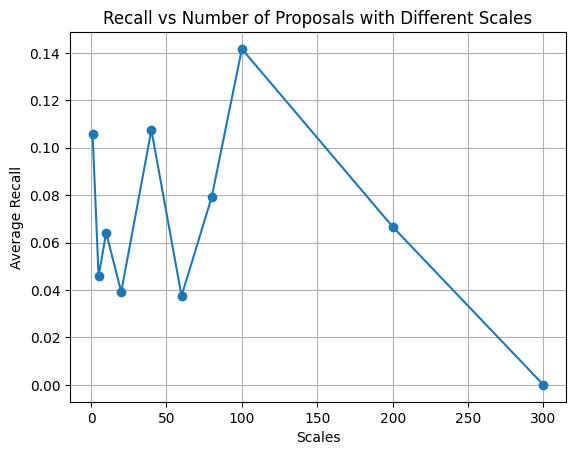

In [16]:
plt.plot(scales, recalls, marker='o')


plt.xlabel("Scales")
plt.ylabel("Average Recall")
plt.title("Recall vs Number of Proposals with Different Scales")
plt.grid()
plt.show()

# Sigma
Testing effect of sigma in selective search

In [7]:
# To change the number of proposals we will vary the scale on the selectivesearch function 
# (this is done to not truncate and have a better distribution of the proposals)
# scales = [25, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000]
sigmas = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# MAX_IMAGES = 20 # Number of image we will take into account to do the recall

# Keep the recalls in a diccionary
results = {sigma: {'num_proposals': 0, 'recall': []} for sigma in sigmas}


# Loop through images to evaluate proposals
image_count = 0
MAX_IMAGES = 20

TARGET_WIDTH = 800
TARGET_HEIGHT = 800
image_paths = np.array(list(filter(lambda file: file.endswith(".jpg"), files)))
label_paths = np.array(list(filter(lambda file: file.endswith(".xml"), files)))

image_paths = sorted(image_paths, key=get_id)
label_paths = sorted(label_paths, key=get_id)

for img_name, label_name in zip(image_paths, label_paths):
    # Stop processing after reaching the limit of images
    if image_count >= MAX_IMAGES:
        break

    image_path = os.path.join(img_path, img_name)
    xml_path = os.path.join(anno_path, label_name)
        
    # Load image and ground truth
    image = cv2.imread(image_path)
    if os.path.exists(xml_path):
        ground_truth_boxes = parse_xml(xml_path)
            
        # Dimensions for resizing image 
        orig_height, orig_width = image.shape[:2]
        scale_x = orig_width
        scale_y = orig_height
            
        # Resize ground truth boxes
        # resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
        # Resize image and generate proposals
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
            

        # Evaluate for each proposal_count
        for sigma in sigmas:
            proposals = get_proposals(resized_image, 5000, scale=100, sigma=sigma, min_size=300 )
            results[sigma]['num_proposals'] += len(proposals)

            # Calculate the recall 
            recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
            results[sigma]['recall'].append(recall)

        image_count += 1
        print (f"{img_name}:{image_count}, {len(proposals)}", end="\r")


# Calculate average recall and the number of proposals for each scale
average_recalls = {sigma: np.mean(results[sigma]['recall']) for sigma in sigmas}

# Prepare data for plotting
average_num_proposals = {sigma: results[sigma]['num_proposals'] / image_count for sigma in sigmas} 

# Sort the scales based on the average number of proposals
# sorted_scales = sorted(average_num_proposals.keys(), key=lambda scale: average_num_proposals[scale])
# sorted_num_proposals = [average_num_proposals[scale] for scale in sorted_scales]
# sorted_recalls = [average_recalls[scale] for scale in sorted_scales]

# Display the results and the number of proposals per scale
# for scale in scales:
#     avg_props = average_num_proposals[scale]
#     avg_recall = average_recalls[scale]
#     print(f"Scale: {scale}, Average Proposals: {avg_props:.2f}, Average Recall: {avg_recall:.2f}")

# Plot the results
plt.figure(figsize=(10, 6))


num_proposals = [results[sigma]['num_proposals'] / image_count for sigma in sigmas]
recalls = [average_recalls[sigma] for sigma in sigmas]


c:\Python312\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

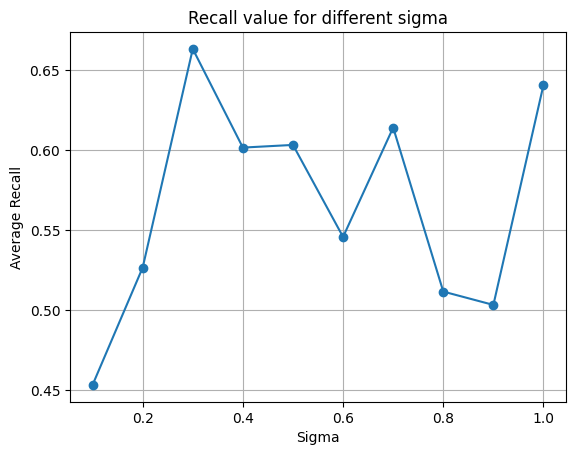

In [8]:
plt.plot(sigmas, recalls, marker='o')


plt.xlabel("Sigma")
plt.ylabel("Average Recall")
plt.title("Recall value for different sigma")
plt.grid()
plt.show()

c:\Python312\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed 40/40 images
Scale	Sigma	Avg Proposals	Avg Recall
----------------------------------------------
15	1.0	538.83		0.39
15	1.1	546.62		0.46
15	1.2	549.67		0.53
15	1.3	550.50		0.40
20	1.0	544.10		0.43
20	1.1	542.38		0.38
20	1.2	537.55		0.42
20	1.3	537.08		0.37
25	1.0	531.88		0.40
25	1.1	525.70		0.38
25	1.2	516.45		0.48
25	1.3	509.57		0.40
30	1.0	509.23		0.45
30	1.1	499.70		0.45
30	1.2	484.32		0.52
30	1.3	470.68		0.38


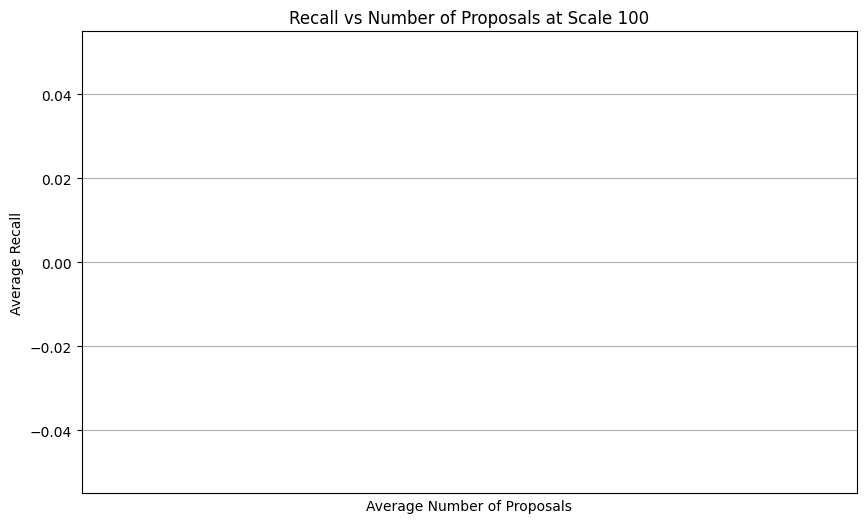

In [10]:
# Define the range of scales and sigmas for hyperparameter tuning
scales = [15, 20, 25, 30]
sigmas = [1.0, 1.1,1.2, 1.3]

# Maximum number of images to process
MAX_IMAGES = 40

# Image dimensions
TARGET_WIDTH = 600
TARGET_HEIGHT = 600

# Initialize results dictionary to store metrics for each (scale, sigma) combination
results = {}


files = os.listdir(img_path)

image_paths = np.array([file for file in files if file.endswith(".jpg")])
label_paths = np.array([file for file in files if file.endswith(".xml")])

# Sort the file lists to ensure correct pairing
image_paths = sorted(image_paths)
label_paths = sorted(label_paths)

# Initialize image counter
image_count = 0

# Loop through images to evaluate proposals
for img_name, label_name in zip(image_paths, label_paths):
    # Stop processing after reaching the limit of images
    if image_count >= MAX_IMAGES:
        break

    image_path = os.path.join(img_path, img_name)
    xml_path = os.path.join(anno_path, label_name)

    # Load image and ground truth
    image = cv2.imread(image_path)
    if image is None:
        continue  # Skip if image failed to load

    if os.path.exists(xml_path):
        ground_truth_boxes = parse_xml(xml_path)  # This function should return a list of boxes in (xmin, ymin, xmax, ymax) format

        # Dimensions for resizing image 
        orig_height, orig_width = image.shape[:2]
        scale_x = TARGET_WIDTH / orig_width
        scale_y = TARGET_HEIGHT / orig_height
            
        # Resize ground truth boxes
        resized_gt_boxes = [(int(xmin * scale_x), int(ymin * scale_y), int(xmax * scale_x), int(ymax * scale_y)) for xmin, ymin, xmax, ymax in ground_truth_boxes]
            
        
        # Resize image
        resized_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))

        # Loop over all combinations of scale and sigma
        for scale in scales:
            for sigma in sigmas:
                key = (scale, sigma)
                if key not in results:
                    results[key] = {'num_proposals': 0, 'recall': [], 'abo': []}

                # Generate proposals with current scale and sigma
                proposals = get_proposals(
                    resized_image,
                    5000,
                    scale=scale,
                    sigma=sigma,
                    min_size=300
                )
                results[key]['num_proposals'] += len(proposals)

                # Calculate the recall
                recall = calc_recall(proposals, ground_truth_boxes, iou_threshold=0.5)
                results[key]['recall'].append(recall)

                # Calculate the ABO
                abo = calc_abo(proposals, ground_truth_boxes)
                results[key]['abo'].append(abo)

        image_count += 1
        print(f"Processed {image_count}/{MAX_IMAGES} images", end="\r")
    else:
        continue  # Skip images without annotations

# Calculate average recall, ABO, and the number of proposals for each (scale, sigma) combination
average_recalls = {key: np.mean(results[key]['recall']) for key in results}
average_abos = {key: np.mean(results[key]['abo']) for key in results}
average_num_proposals = {key: results[key]['num_proposals'] / image_count for key in results}


# Prepare data for plotting or analysis
# You can reshape the results into a grid if you want to visualize them as heatmaps

# Example: Print out the results
print("\nScale\tSigma\tAvg Proposals\tAvg Recall")
print("----------------------------------------------")
for (scale, sigma) in sorted(results.keys()):
    avg_props = average_num_proposals[(scale, sigma)]
    avg_recall = average_recalls[(scale, sigma)]
    print(f"{scale}\t{sigma}\t{avg_props:.2f}\t\t{avg_recall:.2f}")

# If you want to plot recall vs number of proposals for each sigma or scale
# Here's an example for plotting recall vs number of proposals for each sigma at a fixed scale
fixed_scale = 100  # Change this to the scale you want to fix
filtered_keys = [key for key in results if key[0] == fixed_scale]

# Sort the filtered keys based on sigma
filtered_keys.sort(key=lambda x: x[1])

num_proposals = [average_num_proposals[key] for key in filtered_keys]
recalls = [average_recalls[key] for key in filtered_keys]
sigmas_fixed_scale = [key[1] for key in filtered_keys]

plt.figure(figsize=(10, 6))
plt.plot(num_proposals, recalls, marker='o')
plt.xlabel("Average Number of Proposals")
plt.ylabel("Average Recall")
plt.title(f"Recall vs Number of Proposals at Scale {fixed_scale}")
plt.xticks(ticks=num_proposals, labels=[f"{sigma:.1f}" for sigma in sigmas_fixed_scale])
plt.grid()
plt.show()

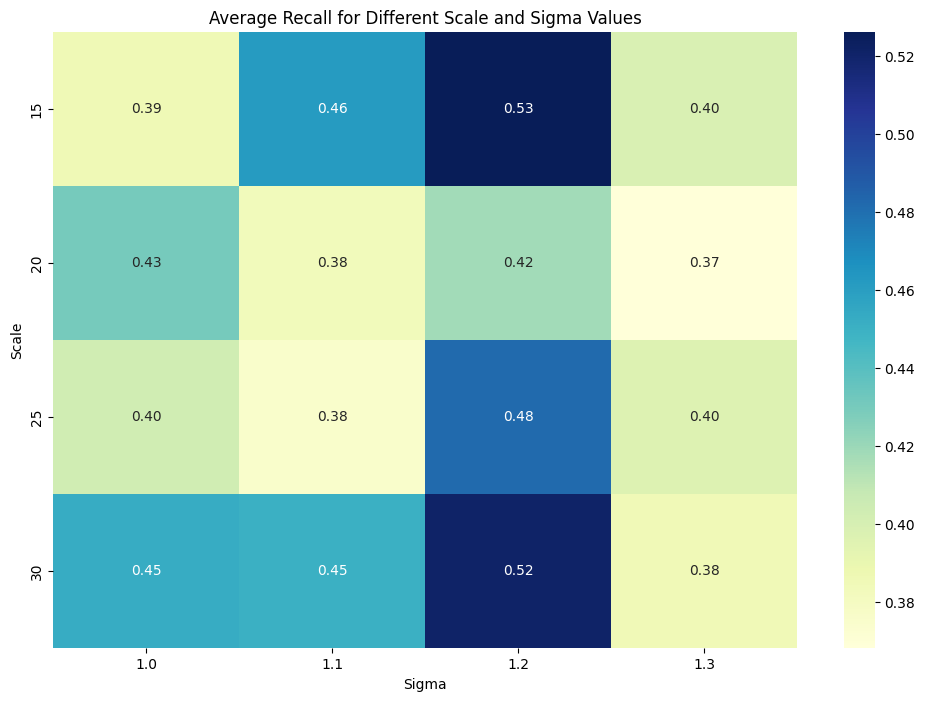

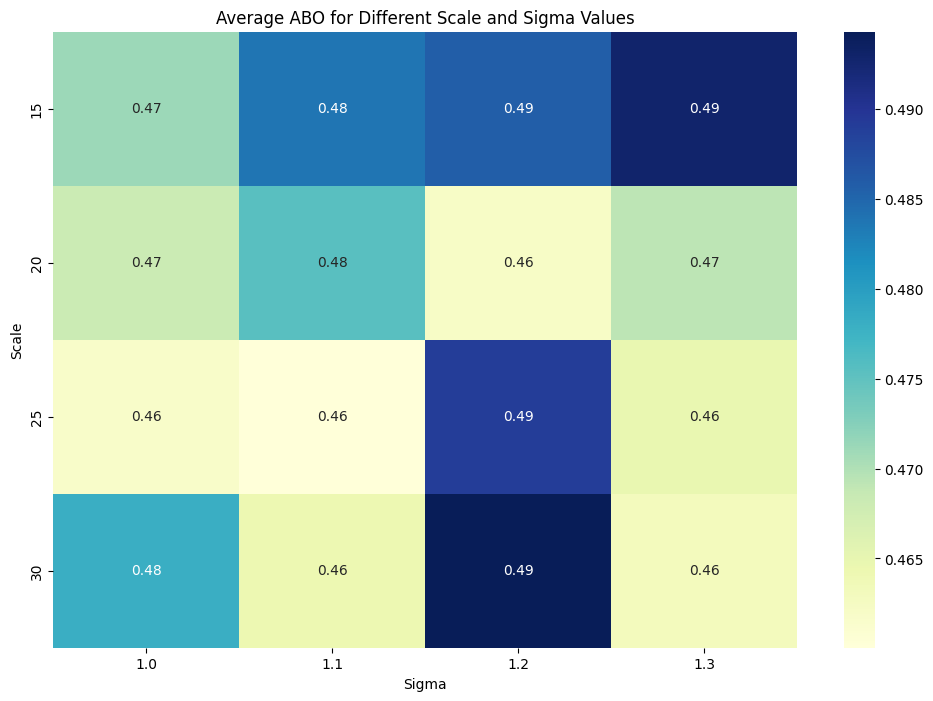

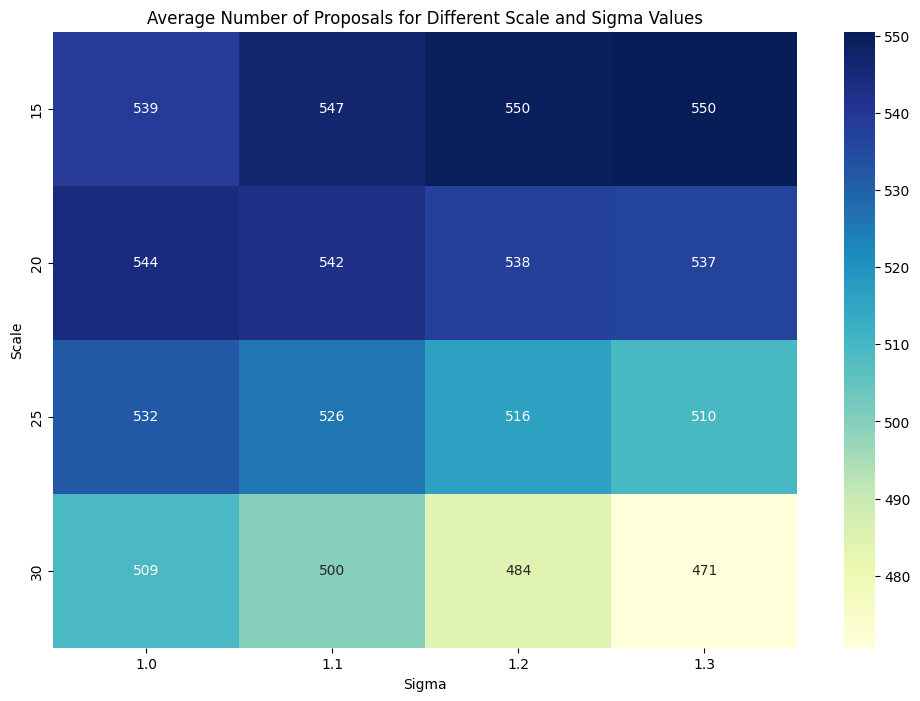

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for plotting or analysis
data = []
for (scale, sigma) in results.keys():
    avg_props = average_num_proposals[(scale, sigma)]
    avg_recall = average_recalls[(scale, sigma)]
    avg_abo = average_abos[(scale, sigma)]
    data.append({'Scale': scale, 'Sigma': sigma, 'Avg Proposals': avg_props, 'Avg Recall': avg_recall, 'Avg ABO': avg_abo})

df = pd.DataFrame(data)

# Pivot the DataFrame to create matrices for heatmaps
recall_pivot = df.pivot(index='Scale', columns='Sigma', values='Avg Recall')
abo_pivot = df.pivot(index='Scale', columns='Sigma', values='Avg ABO')
proposals_pivot = df.pivot(index='Scale', columns='Sigma', values='Avg Proposals')

# Plot heatmap for Average Recall
plt.figure(figsize=(12, 8))
sns.heatmap(recall_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average Recall for Different Scale and Sigma Values')
plt.xlabel('Sigma')
plt.ylabel('Scale')
plt.show()

# Plot heatmap for Average ABO
plt.figure(figsize=(12, 8))
sns.heatmap(abo_pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Average ABO for Different Scale and Sigma Values')
plt.xlabel('Sigma')
plt.ylabel('Scale')
plt.show()

# Plot heatmap for Average Number of Proposals
plt.figure(figsize=(12, 8))
sns.heatmap(proposals_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Average Number of Proposals for Different Scale and Sigma Values')
plt.xlabel('Sigma')
plt.ylabel('Scale')
plt.show()